In [1]:
import pandas as pd
import numpy as np
from glob import glob

from scipy import stats
from scipy.stats import pearsonr
from scipy.interpolate import interpn
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D
%matplotlib inline
import seaborn as sns
sns.set(style='ticks', context='notebook', font_scale=1.2)

In [3]:
cols = ['EA vs SHE (eV)', 'IP vs SHE (eV)']

def get_results(folder, cols):
    num_folds = len(glob(f'{folder}/predictions_*.csv'))
    # check if results are partial
    num_folds_check = len(glob(f'{folder}/input_test_*.csv'))
    if num_folds != num_folds_check:
        print(f'WARNING: only partial results available in "{folder}"')
    df_y_test = pd.DataFrame(columns=cols + ['fold'])
    df_y_pred = pd.DataFrame(columns=cols + ['fold'])  
    for i in range(num_folds):
        y_test = pd.read_csv(f'{folder}/input_test_{i}.csv').loc[:, cols]
        y_pred = pd.read_csv(f'{folder}/predictions_{i}.csv').loc[:, cols]
        y_test.loc[:, 'fold'] = int(i)
        y_pred.loc[:, 'fold'] = int(i)
        df_y_test = df_y_test.append(y_test, ignore_index=True)
        df_y_pred = df_y_pred.append(y_pred, ignore_index=True)
    return df_y_test, df_y_pred


def get_performance(df_y_test, df_y_pred, col):
    kfolds = list(set(df_y_test.loc[:, 'fold']))
    rmses = []
    pears = []
    r2s = []
    for k in kfolds:
        mask = df_y_test.loc[:, 'fold'] == k
        y_test = df_y_test.loc[mask, col]
        y_pred = df_y_pred.loc[mask, col]

        rmse = np.sqrt(np.mean((y_test - y_pred)**2))
        pear = pearsonr(y_test, y_pred)[0]
        r2 = r2_score(y_test, y_pred)

        rmses.append(rmse)
        pears.append(pear)
        r2s.append(r2)
    
    perf = {'rmse':{}, 'pearson':{}, 'r2':{}, 'rmse_lst':rmses, 'pearson_lst':pears, 'r2_lst':r2s}
    perf['rmse']['mean'] = np.mean(rmses)
    perf['rmse']['sem'] = stats.sem(rmses)
    perf['pearson']['mean'] = np.mean(pears)
    perf['pearson']['sem'] = stats.sem(pears)
    perf['r2']['mean'] = np.mean(r2s)
    perf['r2']['sem'] = stats.sem(r2s)
    return perf

In [ ]:
def density_scatter(folder, col, ax=None, sort=True, bins=20, cmap='viridis', ann_label='', ann_color='k', **kwargs):
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        _ , ax = plt.subplots()

    df_y_test, df_y_pred = get_results(folder, [col])
    perf = get_performance(df_y_test, df_y_pred, col)

    x = df_y_test.loc[:, col].to_numpy()
    y = df_y_pred.loc[:, col].to_numpy()

    data , x_e, y_e = np.histogram2d(x, y, bins = bins, density = True )
    z = interpn(
        (0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1])), 
        data,
        np.vstack([x,y]).T,
        method = "splinef2d",
        bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter(x, y, c=z, s=10, cmap=cmap, rasterized=True, **kwargs )

    # parity line
    xlim = ax.get_xlim()
    ax.plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], linestyle='--', color='k')

    # annotate performance
    y = 0.10
    dy = 0.09
    mmap = {'rmse':'RMSE', 'pearson':'Pearson', 'r2':'R^2'}
    for m in ['rmse', 'r2']:
        mean = perf[m]['mean'] 
        sem = perf[m]['sem']
        M = mmap[m]
        if sem < 0.005:
            ax.annotate(f'${M} = {mean:.2f}$', xy=(0.97,y), xycoords='axes fraction', ha='right', va='bottom', color='k')
        else:
            ax.annotate(f'${M} = {mean:.2f} \pm {sem:.2f}$', xy=(0.97,y), xycoords='axes fraction', ha='right', va='bottom', color='k',
                        path_effects=[pe.withStroke(linewidth=3, foreground="white")])
        y -= dy
    
    # annotate title
    ax.annotate(ann_label, xy=(0.03,0.97), xycoords='axes fraction', ha='left', va='top', color=ann_color, weight='bold')

    return ax

## Scatter plots

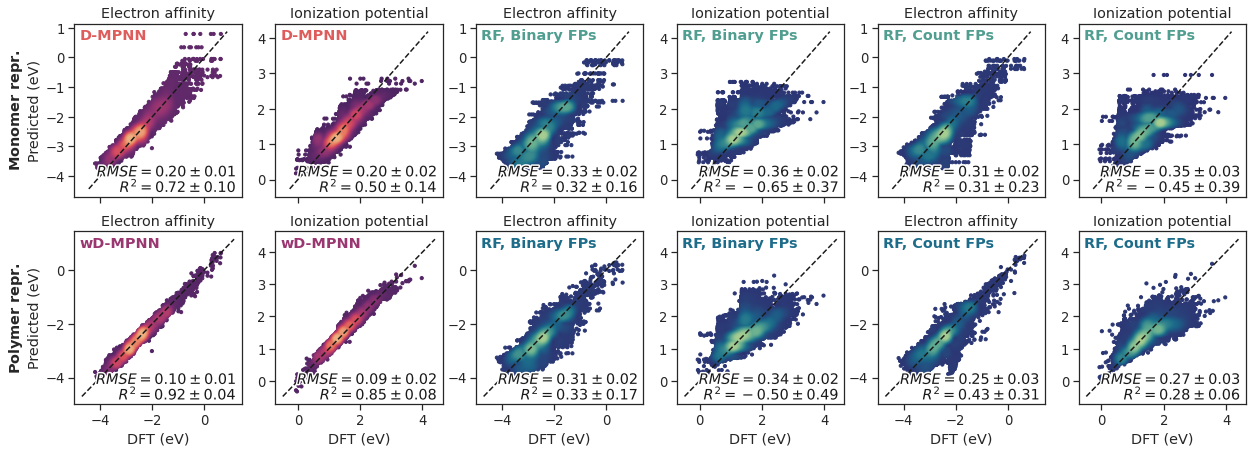

In [75]:
# =====================================
# 2 x 6 scatter, D-MPNN and RF results
# =====================================

ncols = 6
nrows = 2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(3.5*ncols, 3.5*nrows), sharex='col')

#dir_cv = 'cv10-random'  # 10-fold cross-validation with random splits
dir_cv = 'cv9-monomer'  # 9-fold cross-validation with monomer-identity split

rfval = 'w_val'  # RF where the val set was merged with the train set and default hparams were used
#rfval = 'hopt'  # RF where the val set was used for hparam opt


colors = sns.color_palette("flare", 2)
# Chemprop Mono
i = 0
density_scatter(ax=axes[i,0], folder=f'{dir_cv}/master/', col='EA vs SHE (eV)', cmap=sns.color_palette("flare_r", as_cmap=True),
                ann_label='D-MPNN', ann_color=colors[i])
density_scatter(ax=axes[i,1], folder=f'{dir_cv}/master/', col='IP vs SHE (eV)', cmap=sns.color_palette("flare_r", as_cmap=True),
                ann_label='D-MPNN', ann_color=colors[i])

# Chemprop Poly
i = 1
density_scatter(ax=axes[i,0], folder=f'{dir_cv}/polymer/', col='EA vs SHE (eV)', cmap=sns.color_palette("flare_r", as_cmap=True),
                ann_label='wD-MPNN', ann_color=colors[i])
density_scatter(ax=axes[i,1], folder=f'{dir_cv}/polymer/', col='IP vs SHE (eV)', cmap=sns.color_palette("flare_r", as_cmap=True),
                ann_label='wD-MPNN', ann_color=colors[i])

colors = sns.color_palette("crest", 2)
# RF Mono FP Binary
i = 0
density_scatter(ax=axes[i,2], folder=f'{dir_cv}/rf/{rfval}/monomer-repr/fp_binary/', col='EA vs SHE (eV)', cmap=sns.color_palette("crest_r", as_cmap=True),
                ann_label='RF, Binary FPs', ann_color=colors[i])
density_scatter(ax=axes[i,3], folder=f'{dir_cv}/rf/{rfval}/monomer-repr/fp_binary/', col='IP vs SHE (eV)', cmap=sns.color_palette("crest_r", as_cmap=True),
                ann_label='RF, Binary FPs', ann_color=colors[i])

# RF Poly FP Binary
i = 1
density_scatter(ax=axes[i,2], folder=f'{dir_cv}/rf/{rfval}/polymer-repr/fp_binary/', col='EA vs SHE (eV)', cmap=sns.color_palette("crest_r", as_cmap=True),
                ann_label='RF, Binary FPs', ann_color=colors[i])
density_scatter(ax=axes[i,3], folder=f'{dir_cv}/rf/{rfval}/polymer-repr/fp_binary/', col='IP vs SHE (eV)', cmap=sns.color_palette("crest_r", as_cmap=True),
                ann_label='RF, Binary FPs', ann_color=colors[i])

# RF Mono FP Counts
i = 0
density_scatter(ax=axes[i,4], folder=f'{dir_cv}/rf/{rfval}/monomer-repr/fp_counts/', col='EA vs SHE (eV)', cmap=sns.color_palette("crest_r", as_cmap=True),
                ann_label='RF, Count FPs', ann_color=colors[i])
density_scatter(ax=axes[i,5], folder=f'{dir_cv}/rf/{rfval}/monomer-repr/fp_counts/', col='IP vs SHE (eV)', cmap=sns.color_palette("crest_r", as_cmap=True),
                ann_label='RF, Count FPs', ann_color=colors[i])

# RF Poly FP Counts
i = 1
density_scatter(ax=axes[i,4], folder=f'{dir_cv}/rf/{rfval}/polymer-repr/fp_counts/', col='EA vs SHE (eV)', cmap=sns.color_palette("crest_r", as_cmap=True),
                ann_label='RF, Count FPs', ann_color=colors[i])
density_scatter(ax=axes[i,5], folder=f'{dir_cv}/rf/{rfval}/polymer-repr/fp_counts/', col='IP vs SHE (eV)', cmap=sns.color_palette("crest_r", as_cmap=True),
                ann_label='RF, Count FPs', ann_color=colors[i])


for j in range(ncols):
    _ = axes[-1,j].set_xlabel('DFT (eV)')

_ = axes[0,0].set_ylabel(r"$\bf{Monomer\ repr.}$" + "\nPredicted (eV)")
_ = axes[1,0].set_ylabel(r"$\bf{Polymer\ repr.}$" + "\nPredicted (eV)")

for j in range(ncols):
    for i in range(nrows):
        if j % 2 == 0:
            axes[i,j].set_title('Electron affinity')
        else:
            axes[i,j].set_title('Ionization potential')


#fig.savefig(f'{dir_cv}_results_density-scatter.png', dpi=1200, bbox_inches='tight')
fig.savefig(f'{dir_cv}_results_density-scatter.pdf', dpi=1200, bbox_inches='tight')

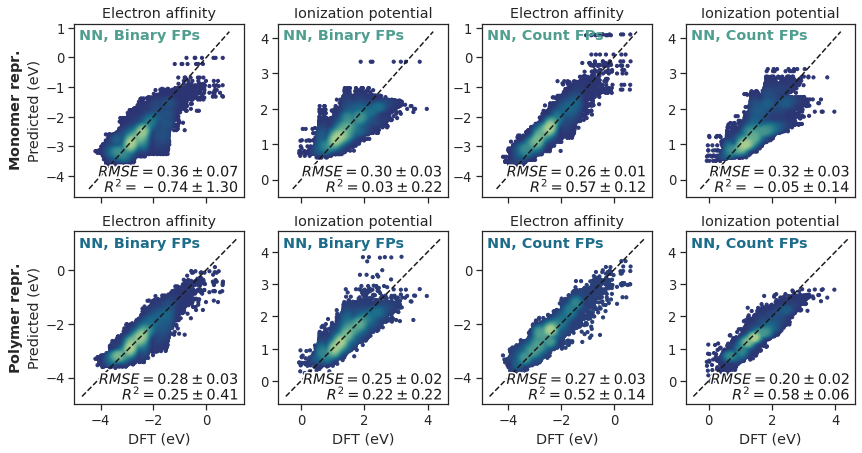

In [6]:
# =========================
# 2 x 4 scatter, NN results
# =========================

ncols = 4
nrows = 2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(3.5*ncols, 3.5*nrows), sharex='col')

#dir_cv = 'cv10-random'  # 10-fold cross-validation with random splits
dir_cv = 'cv9-monomer'  # 9-fold cross-validation with monomer-identity split


colors = sns.color_palette("crest", 2)
# NN Mono FP Binary
i = 0
density_scatter(ax=axes[i,0], folder=f'{dir_cv}/nn/monomer-repr/fp_binary/', col='EA vs SHE (eV)', cmap=sns.color_palette("crest_r", as_cmap=True),
                ann_label='NN, Binary FPs', ann_color=colors[i])
density_scatter(ax=axes[i,1], folder=f'{dir_cv}/nn/monomer-repr/fp_binary/', col='IP vs SHE (eV)', cmap=sns.color_palette("crest_r", as_cmap=True),
                ann_label='NN, Binary FPs', ann_color=colors[i])

# NN Poly FP Binary
i = 1
density_scatter(ax=axes[i,0], folder=f'{dir_cv}/nn/polymer-repr/fp_binary/', col='EA vs SHE (eV)', cmap=sns.color_palette("crest_r", as_cmap=True),
                ann_label='NN, Binary FPs', ann_color=colors[i])
density_scatter(ax=axes[i,1], folder=f'{dir_cv}/nn/polymer-repr/fp_binary/', col='IP vs SHE (eV)', cmap=sns.color_palette("crest_r", as_cmap=True),
                ann_label='NN, Binary FPs', ann_color=colors[i])

# NN Mono FP Counts
i = 0
density_scatter(ax=axes[i,2], folder=f'{dir_cv}/nn/monomer-repr/fp_counts/', col='EA vs SHE (eV)', cmap=sns.color_palette("crest_r", as_cmap=True),
                ann_label='NN, Count FPs', ann_color=colors[i])
density_scatter(ax=axes[i,3], folder=f'{dir_cv}/nn/monomer-repr/fp_counts/', col='IP vs SHE (eV)', cmap=sns.color_palette("crest_r", as_cmap=True),
                ann_label='NN, Count FPs', ann_color=colors[i])

# NN Poly FP Counts
i = 1
density_scatter(ax=axes[i,2], folder=f'{dir_cv}/nn/polymer-repr/fp_counts/', col='EA vs SHE (eV)', cmap=sns.color_palette("crest_r", as_cmap=True),
                ann_label='NN, Count FPs', ann_color=colors[i])
density_scatter(ax=axes[i,3], folder=f'{dir_cv}/nn/polymer-repr/fp_counts/', col='IP vs SHE (eV)', cmap=sns.color_palette("crest_r", as_cmap=True),
                ann_label='NN, Count FPs', ann_color=colors[i])


for j in range(ncols):
    _ = axes[-1,j].set_xlabel('DFT (eV)')

_ = axes[0,0].set_ylabel(r"$\bf{Monomer\ repr.}$" + "\nPredicted (eV)")
_ = axes[1,0].set_ylabel(r"$\bf{Polymer\ repr.}$" + "\nPredicted (eV)")

for j in range(ncols):
    for i in range(nrows):
        if j % 2 == 0:
            axes[i,j].set_title('Electron affinity')
        else:
            axes[i,j].set_title('Ionization potential')

#fig.savefig(f'{dir_cv}_results-nn_density-scatter.png', dpi=1200, bbox_inches='tight')
#fig.savefig(f'{dir_cv}_results-nn_density-scatter.pdf', dpi=1200, bbox_inches='tight')

In [77]:
# ======================
# Print performance info
# ======================

def get_perf_from_folder(col, folder, metric='r2'):
    df_y_test, df_y_pred = get_results(folder, [col])
    perf = get_performance(df_y_test, df_y_pred, col)
    return perf[metric]['mean'], perf[metric]['sem']


folders = ['cv10-random/master/',
           'cv10-random/polymer-only_chain_arch/',
           'cv10-random/polymer-only_stoich/',
           'cv10-random/polymer/',
           #
           'cv10-random/master-poly_type_x5/',
           'cv10-random/polymer-only_chain_arch-poly_type_x5/',
           'cv10-random/polymer-only_stoich-poly_type_x5/',
           'cv10-random/polymer-poly_type_x5/',
           #
           'cv10-random/master-comp_x5/',
           'cv10-random/polymer-only_chain_arch-comp_x5/',
           'cv10-random/polymer-only_stoich-comp_x5/',
           'cv10-random/polymer-comp_x5/']

#col = 'EA vs SHE (eV)'
col = 'IP vs SHE (eV)'

for folder in folders:
    c = col
    if 'comp_x5' in folder:
        c += ' comp_x5'
    if 'poly_type_x5' in folder:
        c += ' poly_type_x5'

    mean, sem = get_perf_from_folder(col=c, folder=folder, metric='rmse')
    print(folder)
    print(f"{mean:.2f} +/- {sem:.2f}")
    print()

cv10-random/master/
0.16 +/- 0.00

cv10-random/polymer-only_chain_arch/
0.15 +/- 0.00

cv10-random/polymer-only_stoich/
0.07 +/- 0.00

cv10-random/polymer/
0.03 +/- 0.00

cv10-random/master-poly_type_x5/
0.33 +/- 0.00

cv10-random/polymer-only_chain_arch-poly_type_x5/
0.21 +/- 0.00

cv10-random/polymer-only_stoich-poly_type_x5/
0.30 +/- 0.00

cv10-random/polymer-poly_type_x5/
0.08 +/- 0.00

cv10-random/master-comp_x5/
0.74 +/- 0.00

cv10-random/polymer-only_chain_arch-comp_x5/
0.74 +/- 0.00

cv10-random/polymer-only_stoich-comp_x5/
0.14 +/- 0.00

cv10-random/polymer-comp_x5/
0.09 +/- 0.00



## Data efficiency

In [6]:
def aggregate_separate_test_score_csvs(folder):

    result_dict = {}
    result_dict['rmse'] = []
    result_dict['r2'] = []
    result_dict['train_size'] = []
    result_dict['repeat'] = []
    result_dict['property'] = []


    test_score_csvs = glob(f'{folder}/test_scores*csv')
    for csv in test_score_csvs:
        df = pd.read_csv(csv)

        train_size = float(csv.split('/')[-1].split('-')[1].split('_')[0])
        repeat = int(csv.split('/')[-1].split('-')[1].split('_')[1].split('.')[0])

        result_dict['property'].extend(df.loc[:, 'Task'])
        result_dict['rmse'].extend(df.loc[:, 'Mean rmse'])
        result_dict['r2'].extend(df.loc[:, 'Mean r2'])
        result_dict['train_size'].extend([train_size] * len(df))
        result_dict['repeat'].extend([repeat] * len(df))

    df = pd.DataFrame(result_dict)
    df = df.sort_values(by=['train_size', 'repeat'])
    df = df.reset_index(drop=True)

    return df


def get_mean_and_sem_from_dataeff_df(df, col, metric='r2', skip=[]):
    means = []
    sems = []
    train_sizes = []
    _train_sizes = sorted(list(set(df.loc[:, 'train_size'])))
    
    for train_size in _train_sizes:
        if train_size in skip:
            continue
        mask0 = df.loc[:, 'property'] == col
        mask1 = df.loc[:, 'train_size'] == train_size
        mask = np.logical_and(mask0, mask1)

        mean = np.mean(df.loc[mask, metric])
        sem = stats.sem(df.loc[mask, metric])

        means.append(mean)
        sems.append(sem)
        train_sizes.append(train_size)

    return train_sizes, means, sems

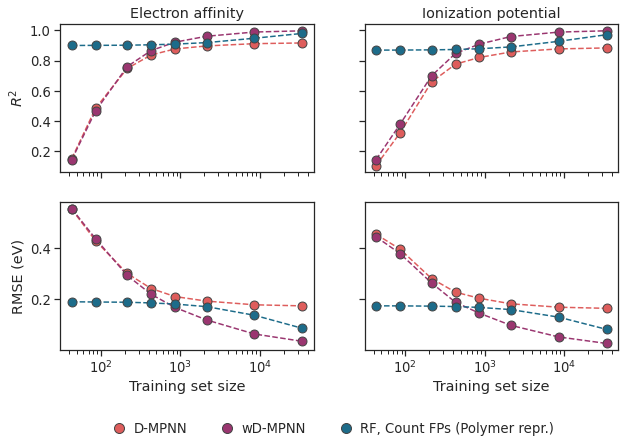

In [9]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,6), sharey='row', sharex=True)


def plot_dataeff(df, col, metric, ax, color):
    train_sizes, means, sems = get_mean_and_sem_from_dataeff_df(df, col=col, metric=metric)
    train_sizes = np.around(np.array(train_sizes) * 42966, 0)
    ax.plot(train_sizes, means, color=color, linestyle='--', zorder=0)
    ax.scatter(train_sizes, means, s=80, color=color, zorder=1, edgecolor='#444444', linewidth=1)


# =========
# LEFT PLOT
# =========
col = 'EA vs SHE (eV)'
j = 0

colors = sns.color_palette("flare", 2)
# Master
df = aggregate_separate_test_score_csvs('data-efficiency/master/')
plot_dataeff(df=df, col=col, metric='r2', color=colors[0],  ax=axes[0,j])
plot_dataeff(df=df, col=col, metric='rmse', color=colors[0],  ax=axes[1,j])

# Poly Chemprop
df = aggregate_separate_test_score_csvs('data-efficiency/polymer/')
plot_dataeff(df=df, col=col, metric='r2', color=colors[1],  ax=axes[0,j])
plot_dataeff(df=df, col=col, metric='rmse', color=colors[1],  ax=axes[1,j])


colors = sns.color_palette("crest", 2)

# RF Poly, Count FPs
df = pd.read_csv('data-efficiency/rf/polymer-repr/w_val/fp_counts/test_score-w_val.csv')
plot_dataeff(df=df, col=col, metric='r2', color=colors[1],  ax=axes[0,j])
plot_dataeff(df=df, col=col, metric='rmse', color=colors[1],  ax=axes[1,j])


# ==========
# RIGHT PLOT
# ==========
col = 'IP vs SHE (eV)'
j = 1

colors = sns.color_palette("flare", 2)
# Master
df = aggregate_separate_test_score_csvs('data-efficiency/master/')
plot_dataeff(df=df, col=col, metric='r2', color=colors[0],  ax=axes[0,j])
plot_dataeff(df=df, col=col, metric='rmse', color=colors[0],  ax=axes[1,j])

# Poly Chemprop
df = aggregate_separate_test_score_csvs('data-efficiency/polymer/')
plot_dataeff(df=df, col=col, metric='r2', color=colors[1],  ax=axes[0,j])
plot_dataeff(df=df, col=col, metric='rmse', color=colors[1],  ax=axes[1,j])


colors = sns.color_palette("crest", 2)
# RF Poly, Count FPs
df = pd.read_csv('data-efficiency/rf/polymer-repr/w_val/fp_counts/test_score-w_val.csv')
plot_dataeff(df=df, col=col, metric='r2', color=colors[1],  ax=axes[0,j])
plot_dataeff(df=df, col=col, metric='rmse', color=colors[1],  ax=axes[1,j])

# ------
# Labels
# ------

_ = axes[1,0].set_xlabel('Training set size')
_ = axes[1,1].set_xlabel('Training set size')

_ = axes[0,0].set_ylabel('$R^2$')
_ = axes[1,0].set_ylabel('RMSE (eV)')

_ = axes[0,0].set_title('Electron affinity')
_ = axes[0,1].set_title('Ionization potential')


# legend
ms = 10
c0 = sns.color_palette("flare", 2)[0]
c1 = sns.color_palette("flare", 2)[1]
c2 = sns.color_palette("crest", 2)[1]
legend_elements = [Line2D([0], [0], marker='o', linestyle='None', color=c0, label='D-MPNN', markerfacecolor=c0, markersize=ms, markeredgecolor='#444444'),
                   Line2D([0], [0], marker='o', linestyle='None', color=c1, label='wD-MPNN', markerfacecolor=c1, markersize=ms, markeredgecolor='#444444'),
                   Line2D([0], [0], marker='o', linestyle='None', color=c2, label='RF, Count FPs (Polymer repr.)', markerfacecolor=c2, markersize=ms, markeredgecolor='#444444')]

#fig.legend(handles=legend_elements, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.2), frameon=False)
lgd = fig.legend(handles=legend_elements, loc='lower center', ncol=3, handletextpad=0.1,
                 bbox_to_anchor=(0.5, -0.1), frameon=False, bbox_transform=fig.transFigure)

axes[0,0].set_xscale('log', base=10)

fig.savefig('data-efficiency.png', dpi=1200, bbox_inches='tight')

In [37]:
#dir_cv = 'cv10-random'
dir_cv = 'cv9-monomer'

#rfapp = 'w_val'
rfapp = 'hopt'

#col = 'EA vs SHE (eV)'
col = 'IP vs SHE (eV)'

folders = [f'{dir_cv}/rf/{rfapp}/monomer-repr/fp_binary/',
           f'{dir_cv}/rf/{rfapp}/monomer-repr/fp_counts/',
           f'{dir_cv}/rf/{rfapp}/polymer-repr/fp_binary/',
           f'{dir_cv}/rf/{rfapp}/polymer-repr/fp_counts/']

for folder in folders:
    rmse, rmse_sem = get_perf_from_folder(col=col, folder=folder, metric='rmse')
    print(folder)
    print(f"{rmse:.3f} +/- {rmse_sem:.3f}")
    print()

cv9-monomer/rf/hopt/monomer-repr/fp_binary/
0.399 +/- 0.036

cv9-monomer/rf/hopt/monomer-repr/fp_counts/
0.378 +/- 0.047

cv9-monomer/rf/hopt/polymer-repr/fp_binary/
0.388 +/- 0.041

cv9-monomer/rf/hopt/polymer-repr/fp_counts/
0.297 +/- 0.050

